# Triangulation
Useful links:
- [ ] https://www.youtube.com/watch?v=UZlRhEUWSas
- [ ] https://en.wikipedia.org/wiki/Triangulation_(computer_vision)
- [ ] https://gist.github.com/cr333/0d0e6c256f93c0ed7bd2
- [ ] https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/autonomous-vision/lectures/computer-vision/
- [ ] https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html
- [ ] https://www.changjiangcai.com/files/text-books/Richard_Hartley_Andrew_Zisserman-Multiple_View_Geometry_in_Computer_Vision-EN.pdf
- [ ] https://medium.com/@insight-in-plain-sight/estimating-the-homography-matrix-with-the-direct-linear-transform-dlt-ec6bbb82ee2b
- [ ] https://glowingpython.blogspot.com/2011/06/svd-decomposition-with-numpy.html

In [15]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2 as cv
import scipy
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol
from sympy import Poly

np.set_printoptions(precision=7,suppress=True)


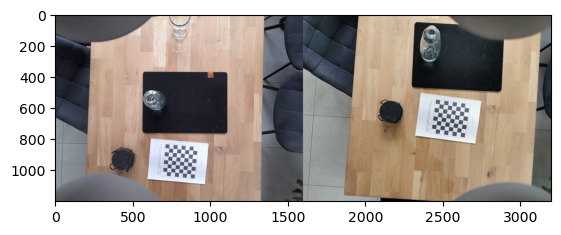

In [3]:
img_size = (1600, 1200)
def printImg(img1, img2, store=''):
    out = cv.hconcat([img1,img2])
    if store != "":
        cv.imwrite(store, out)
    out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
    out = cv.resize(out, (3200,1200))
    plt.imshow(out)

imgL=cv.imread('assets/calibration/left-04.jpg')
imgL=cv.resize(imgL, img_size)
imgR=cv.imread('assets/calibration/right-04.jpg')
imgR=cv.resize(imgR, img_size)
printImg(imgL,imgR)

# retrieved from calibration for images 04
Pp = np.matrix([[ 6.12430486e+02, -9.29557380e+02,  8.04197963e+02,
         9.98847541e+05],
       [ 8.35836177e+02,  5.46965600e+02,  6.29515656e+02,
         4.76432546e+05],
       [ 3.87999651e-04, -1.16635373e-01,  9.93174727e-01,
         7.88766677e+02]])
P = np.matrix([[-2.07810101e+02, -9.57532647e+02,  9.19420275e+02,
         4.99058538e+05],
       [ 6.41846643e+02,  1.77844561e+02,  9.33546842e+02,
         6.25080797e+05],
       [-3.98103114e-01,  4.43355772e-03,  9.17329959e-01,
         7.76363781e+02]])


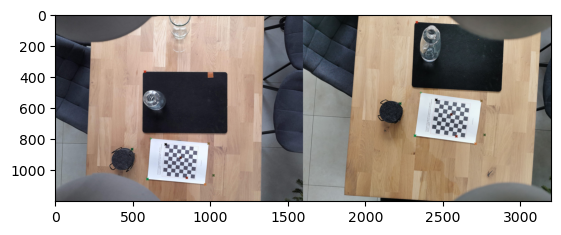

In [12]:
def drawMarkers(img, points):
    tmp = img.copy()
    for i in range(0,len(points)):
        point = (points[i,0],points[i,1])
        marker = cv.MARKER_STAR if i != 9 else cv.MARKER_CROSS
        tmp = cv.drawMarker(tmp, point, (i/8*64%256,i/4*64%256,i*64%256), markerType=marker, markerSize=15, thickness=2, line_type=cv.LINE_AA)
    return tmp

#F,pL,pR = findFundamental(imgL, imgR)
pR = np.array([[859,547],[956,641],[989,782],[734,46],[627,571],[1171,773],[1151,554],[1113,830],[722,778],[760,500]])
pL = np.array([[714,834],[810,920],[850,1050],[580,365],[497,865],[1022,1034],[991,829],[968,1092],[596,1058],[618,796]])
tmpL = drawMarkers(imgL, pL)
tmpR = drawMarkers(imgR, pR)
printImg(tmpL,tmpR,'assets/markers.jpg')

In [5]:
assert pL.shape == pR.shape
ones = np.ones((len(pL),1))
# to homogeneous coordinates
p1 = np.concatenate((pL, ones), axis=1)
p2 = np.concatenate((pR, ones), axis=1)
print(p1,'\n',p2)
F,mask = cv.findFundamentalMat(p1,p2)
print("Fundamental matrix F:\n",F)

[[ 714.  834.    1.]
 [ 810.  920.    1.]
 [ 850. 1050.    1.]
 [ 580.  365.    1.]
 [ 497.  865.    1.]
 [1022. 1034.    1.]
 [ 991.  829.    1.]
 [ 968. 1092.    1.]
 [ 596. 1058.    1.]
 [ 618.  796.    1.]] 
 [[ 859.  547.    1.]
 [ 956.  641.    1.]
 [ 989.  782.    1.]
 [ 734.   46.    1.]
 [ 627.  571.    1.]
 [1171.  773.    1.]
 [1151.  554.    1.]
 [1113.  830.    1.]
 [ 722.  778.    1.]
 [ 760.  500.    1.]]
Fundamental matrix F:
 [[-0.         0.0000009 -0.002265 ]
 [-0.0000006 -0.0000002  0.0017353]
 [ 0.0019145 -0.0020258  1.       ]]


In [6]:
p_index = 0
ptL = pL[p_index]
ptR = pR[p_index]
Tl = np.matrix([[1,0,-ptL[0]],[0,1,-ptL[1]],[0,0,1]])
Tr = np.matrix([[1,0,-ptR[0]],[0,1,-ptR[1]],[0,0,1]])
print("T left")
print(Tl)
print("T right")
print(Tr)

T left
[[   1    0 -714]
 [   0    1 -834]
 [   0    0    1]]
T right
[[   1    0 -859]
 [   0    1 -547]
 [   0    0    1]]


In [7]:
# (ii)
Fp = Tr.T.I.dot(F).dot(Tl.I)
print("Fp")
print(Fp)

Fp
[[-0.         0.0000009 -0.0015335]
 [-0.0000006 -0.0000002  0.0011747]
 [ 0.0015685 -0.0013438  0.0027345]]


In [8]:
# (iii)
def normalize(e):
    factor = np.sqrt(e[0]**2 + e[1]**2)
    #print(factor)
    return e/factor

def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = np.compress(null_mask, vh, axis=0)
    res= np.squeeze(np.asarray(null_space.T))
    #print(res)
    return res

eL = normalize(null(Fp))
eR = normalize(null(Fp.T))

print(eL,"\n\n",eR)


[0.6501769 0.7597829 0.0004346] 

 [-0.6084681 -0.7935783 -0.0003103]


In [9]:
# (iv)
def constructR(e):
    return np.matrix([[e[0],e[1],0],[-e[1],e[0],0],[0,0,1]])
Rl = constructR(eL)
Rr = constructR(eR)
print(Rl,'\n\n',Rr)
print("\nChecks:")
print(Rl.dot(eL))
print(Rr.dot(eR))

[[ 0.6501769  0.7597829  0.       ]
 [-0.7597829  0.6501769  0.       ]
 [ 0.         0.         1.       ]] 

 [[-0.6084681 -0.7935783  0.       ]
 [ 0.7935783 -0.6084681  0.       ]
 [ 0.         0.         1.       ]]

Checks:
[[ 1.        -0.         0.0004346]]
[[ 1.        -0.        -0.0003103]]


In [10]:
# (v)
Fpp = Rr.dot(Fp).dot(Rl.T)
print(Fpp)

[[-0.        -0.0000006  0.0000008]
 [ 0.0000008  0.0000003 -0.0019317]
 [-0.0000012 -0.0020654  0.0027345]]


In [11]:
# (vi)
fL = eL[2]
fR = eR[2]
a = Fpp[1,1]
b = Fpp[1,2]
c = Fpp[2,1]
d = Fpp[2,2]
print("f = {fL}, f' = {fR}, a = {a}, b = {b}, c = {c}, d = {d}".format(**locals()))

f = 0.0004345989370654285, f' = -0.0003103286955876033, a = 2.665517151388019e-07, b = -0.0019317178159197468, c = -0.0020654439472088003, d = 0.0027345479364073782


In [12]:
# (vii)
def get_g_t():
    t = Symbol("t")
    g_t = t*((a*t+b)**2+fR**2*(c*t+d)**2)**2-(a*d-b*c)*(1+(fL**2)*(t**2))**2*(a*t+b)*(c*t+d)
    return g_t, t

def solve_gt():
    g_t, t = get_g_t()
    return solve(g_t, t)
def solve_roots():
    g_t, t = get_g_t()
    coeffs = Poly(g_t,t).all_coeffs()
    print(coeffs)
    return np.roots(coeffs)
    
roots = solve_roots()
print('')
print(roots)

[-7.83478864144373e-29, 8.00111968369935e-25, -1.82392313703381e-21, 1.06725229747629e-17, -9.89779121883290e-15, 2.98432906376892e-11, -2.10720591765462e-11]

[9182.988119    +0.j          34.8221405+3049.70938j
   34.8221405-3049.70938j    479.4797018+2056.2845191j
  479.4797018-2056.2845191j    0.7062556   +0.j       ]


In [13]:
# (viii)
def evaluate_cost(t):
    t=np.real(t)
    return t**2/(1+fL**2*t**2) + (c*t+d)**2/((a*t+b)**2+fR**2*(c*t+d)**2)
costs = np.array([evaluate_cost(t) for t in roots]).real
C = 1/fL**2+c**2/(a**2+fR**2*c**2)
t_min = roots[np.argmin(costs)].real
print(t_min)
print(costs)

0.7062556425856862
[15286269.1541669     2507.4284582     2507.4284582   511657.4225328
   511657.4225328        0.9350854]


In [14]:
# (ix)
def closest(l):
    return np.array([-l[0]*l[2],-l[1]*l[2],l[0]**2+l[1]**2])
l = np.array([t_min*fL,1,-t_min])
lp = np.array([-fR*(c*t_min + d), a*t_min+b,c*t_min+d])
hx = closest(l)
hxp = closest(lp)
print(hx)
print(hxp)

[0.0002168 0.7062556 1.0000001]
[-0.         0.0000025  0.0000037]


In [15]:
# (x)
hx2 = Tl.I.dot(Rl.T).dot(hx)
print(hx2)
hxp2 = Tr.I.dot(Rr.T).dot(hxp)
print(hxp2)

[[713.4636073 834.4594344   1.0000001]]
[[0.0032067 0.0020393 0.0000037]]


In [16]:
def getT(p,pp):
    T = np.matrix([[1,0,-p[0]],[0,1,-p[1]],[0,0,1]])
    Tp = np.matrix([[1,0,-pp[0]],[0,1,-pp[1]],[0,0,1]])
    return T,Tp

def normalize(e):
    factor = np.sqrt(e[0]**2 + e[1]**2)
    #print(factor)
    return e/factor

# copied from other resource
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = np.compress(null_mask, vh, axis=0)
    res= np.squeeze(np.asarray(null_space.T))
    #print(res)
    return res

def get_es(F):
    _,_,v = np.linalg.svd(F)
    e = v[-1]
    ep = np.dot(F, e)

def constructR(e):
    return np.matrix([[e[0],e[1],0],[-e[1],e[0],0],[0,0,1]])

def get_g_t():
    t = Symbol("t")
    g_t = t*((a*t+b)**2+fR**2*(c*t+d)**2)**2-(a*d-b*c)*(1+(fL**2)*(t**2))**2*(a*t+b)*(c*t+d)
    return g_t, t

def solve_gt():
    g_t, t = get_g_t()
    return solve(g_t, t)

def solve_roots():
    g_t, t = get_g_t()
    coeffs = Poly(g_t,t).all_coeffs()
    #print(coeffs)
    return np.roots(coeffs)

def evaluate_cost(t):
    t=np.real(t)
    return t**2/(1+fL**2*t**2) + (c*t+d)**2/((a*t+b)**2+fR**2*(c*t+d)**2)

def closest(l):
    return np.array([-l[0]*l[2],-l[1]*l[2],l[0]**2+l[1]**2])

def singlePointStep(F, p, pp):
    # (i)
    T,Tp = getT(p,pp)
    #print("T")
    #print(T)
    #print("Tp")
    #print(Tp)
    # (ii)
    Fp = Tp.T.I.dot(F).dot(T.I)
    #print("Fp")
    #print(Fp)

    # (iii)
    #e, ep = get_es(Fp)
    #e = normalize(e)
    #ep = normalize(ep)
    e = normalize(null(Fp))
    ep = normalize(null(Fp.T))
    #print("epipoles\n",e,"\n\n",ep)

    # (iv)
    R = constructR(e)
    Rp = constructR(ep)
    #print(R,'\n\n',Rp)
    #print("\nChecks:")
    #print(R.dot(e))
    #print(Rp.dot(ep))

    # (v)
    Fpp = Rp.dot(Fp).dot(R.T)
    #print(Fpp)

    # (vi)
    f = e[2]
    fp = ep[2]
    a = Fpp[1,1]
    b = Fpp[1,2]
    c = Fpp[2,1]
    d = Fpp[2,2]
    #print("f = {f}, f' = {fp}, a = {a}, b = {b}, c = {c}, d = {d}".format(**locals()))

    # (vii)
    roots = solve_roots().real
    #print('')
    #print(roots)

    # (viii)
    costs = np.array([evaluate_cost(t) for t in roots])
    #C = 1/fL**2+c**2/(a**2+fR**2*c**2)
    t_min = roots[np.argmin(costs)]
    #print(t_min)
    #print(costs)

    # (ix)
    l = np.array([t_min*f,1,-t_min])
    #print("l",l)
    lp = np.array([-fp*(c*t_min + d), a*t_min+b,c*t_min+d])
    #print("lp",lp)
    hx = closest(l)
    hxp = closest(lp)
    #print("hx",hx)
    #print("hxp",hxp)

    # (x)
    hx2 = T.I.dot(R.T).dot(hx)
    #print(hx2)
    hxp2 = Tp.I.dot(Rp.T).dot(hxp)
    #print(hxp2)
    return np.squeeze(np.asarray(hx2)), np.squeeze(np.asarray(hxp2))

# from https://gist.githubusercontent.com/hq-jiang/dbd60777a9956b411fbd7458fdb89cf7/raw/1af2ec145fed4048e8d1fc170477e70ed177f3c9/homography_estimation.py
def find_homography(points_source, points_target, P1, P2):
    A  = construct_A_v3(points_source, points_target, P1,P2)
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    
    # Solution to H is the last column of V, or last row of V transpose
    homography = vh[-1]
    #print(homography)
    return homography
    #return homography/homography[3]

# from https://gist.githubusercontent.com/hq-jiang/dbd60777a9956b411fbd7458fdb89cf7/raw/1af2ec145fed4048e8d1fc170477e70ed177f3c9/homography_estimation.py
def construct_A(points_source, points_target):
    assert points_source.shape == points_target.shape, "Shape does not match"
    num_points = points_source.shape[0]

    matrices = []
    for i in range(num_points):
        partial_A = construct_A_partial(points_source[i], points_target[i])
        matrices.append(partial_A)
    return np.concatenate(matrices, axis=0)

# from https://gist.githubusercontent.com/hq-jiang/dbd60777a9956b411fbd7458fdb89cf7/raw/1af2ec145fed4048e8d1fc170477e70ed177f3c9/homography_estimation.py
def construct_A_partial(point_source, point_target):
    x, y, z = point_source[0], point_source[1], 1
    x_t, y_t, z_t = point_target[0], point_target[1], 1

    A_partial = np.array([
        [0, 0, 0, -z_t*x, -z_t*y, -z_t*z, y_t*x, y_t*y, y_t*z],
        [z_t*x, z_t*y, z_t*z, 0, 0, 0, -x_t*x, -x_t*y, -x_t*z]
    ])
    return A_partial  

def construct_A_v2(points1, points2):
    # Number of correspondences
    n = len(points1)

    # Initialize A
    A = np.zeros((2*n, 9))

    for i in range(n):
        x1, y1, _ = points1[i]
        x2, y2, _ = points2[i]
        A[2*i] = [-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2]
        A[2*i+1] = [0, 0, 0, -x1, -y1, -1, x1*y2, y1*y2, y2]
    return A

def construct_A_v3(point1, point2, P, Pp):
    #print(Pp)
    x, y, _ = point1
    xp, yp, _ = point2
    p1 = P[0]
    p2 = P[1]
    p3 = P[2]
    pp1 = Pp[0]
    pp2 = Pp[1]
    pp3 = Pp[2]
    A = np.zeros((4,4))
    A[0] = x*p3-p1
    A[1] = y*p3-p2
    A[2] = xp*pp3-pp1
    A[3] = yp*pp3-pp2
    #print(A)
    return A

def createProjectionMatrices(F):
    # Compute the SVD of F
    _, _, V = np.linalg.svd(F)

    # Construct the first camera matrix P1
    P1 = np.hstack((V[:,:3], V[:,-1].reshape(-1,1)))

    # Construct the second camera matrix P2
    t = np.cross(V[:,0], V[:,1]).reshape(3,1)
    P2 = np.hstack((V[:,:3], t))
    print(P1)
    print(P2)
    assert P1.shape == P2.shape
    return P1, P2
    

def triangulation(img1, img2, pts1, pts2):
    assert pts1.shape == pts2.shape
    ones = np.ones((len(pts1),1))
    #p1 = np.concatenate((pts1, ones), axis=1)
    #p2 = np.concatenate((pts2, ones), axis=1)
    F,mask = cv.findFundamentalMat(p1,p2,cv.FM_LMEDS)
    #P, Pp = createProjectionMatrices(F)
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    print("Fundamental matrix F:\n",F, '\n')
    #print([singlePointStep(F,pts1[i],pts2[i]) for i in range(0,len(pts1))])
    hpts1 = []
    hpts2 = []
    res = []
    for i in range(0,len(pts1)):
        hx,hxp = singlePointStep(F,pts1[i],pts2[i])
        hpts1.append(hx)
        hpts2.append(hxp)
        X = find_homography(hx,hxp, P,Pp)
        res.append(X)
        #print("X for {hx} <-> {hxp}:\nHZ: {X}".format(**locals()))
        #print(X)
    #print(hpts1)
    #print("\nA:")
    printImg(drawMarkers(imgL.copy(),pts1), drawMarkers(imgR.copy(),pts2),"assets/inlier-markers.jpg")
    #print(A)
    return np.matrix(res)
def triangulateOpenCv(P1,P2,pts1,pts2):
    try:
        pts1 = pts1.T
        pts2 = pts2.T
        cv_res = cv.triangulatePoints(P1,P2,pts1,pts2)
        cv_res = np.float32(cv_res.T)
        #print(cv_res)
        #for i in range(0,cv_res.shape[0]):
        #    cv_res[i] = cv_res[i]/cv_res[i,-1]
    except:
        print("error")
    return cv_res

Fundamental matrix F:
 [[-0.         0.0000009 -0.002265 ]
 [-0.0000006 -0.0000002  0.0017353]
 [ 0.0019145 -0.0020258  1.       ]] 

[[ 0.2669279 -0.0940288 -0.9591182  0.0005878]
 [-0.2118397  0.0763793  0.974315  -0.0006606]
 [ 0.676076  -0.2455086 -0.6947278 -0.0000776]
 [ 0.3154349 -0.2001349 -0.9276026  0.000488 ]
 [-0.2856369  0.0431115  0.9573675 -0.0005884]
 [-0.1922632  0.0469528  0.9802193 -0.0006931]
 [ 0.3520431 -0.1708789 -0.9202532  0.0004468]]


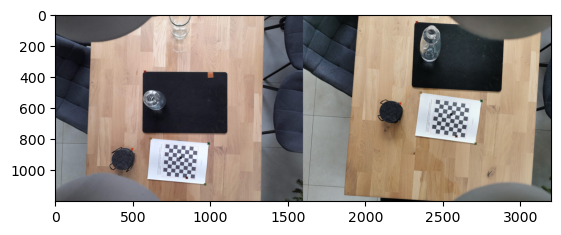

In [17]:
res = triangulation(imgL, imgR, pL, pR)
#cv_res = triangulateOpenCv(P,Pp,pL,pR)
print(res)
#print(cv_res)

In [18]:
def findFundamental(img1, img2):
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) #queryimage # left image
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY) #trainimage # right image
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    return F, pts1,pts2

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

def drawEpipolarLinesCV():
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    cv.imwrite('assets/epiL.jpg',img5)
    cv.imwrite('assets/epiR.jpg',img3)
    plt.show()

In [19]:
#imgL = cv.resize(imgL, (2400,1800))
#imgR = cv.resize(imgR, (2400,1800))

#F, ptsL, ptsR = findFundamental(imgL, imgR)

In [20]:
#print(F)
#tmpL = drawMarkers(imgL,ptsL)
#tmpR = drawMarkers(imgR,ptsR)
#printImg(tmpL,tmpR,'assets/markers.jpg')

In [21]:
#drawEpipolarLinesCV()

In [22]:
#def extractCameraMatrices(F):
#    P1 = np.array([1,0,0,0],[0,1,0,0],[0,0,1,0]])
    